In [1]:
# import modules and packages

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import bar_chart_race as bcr
import statsmodels.api as sm
#from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 60)


In [2]:
# define font and figure size of graph
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

In [3]:
time_series_data = 'data/Records_covid19.csv'
non_time_series_data = 'data/cases04072020.csv'

In [7]:
#Loading Data

def load_tm_data():
    #print('f Loading data from {filename} ...')
    df = pd.read_csv(time_series_data, parse_dates=['Dates'], index_col='Dates')
    print(f'shape of data {df.shape}')
    print(f'checking for missing values {df.info()}')
    return df

def load_ntm_data():
    #print(f'Loading data from .. {file_name}')
    df = pd.read_csv(non_time_series_data)
    print(f'shape of data: {df.shape}')
    print(f'checking for missing data: {df.info()}')
    return df

#deathby_state = pd.read_csv('data/cases27062020.csv')

In [8]:

covid_ng2 = load_ntm_data()

shape of data: (36, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
States Affected                 36 non-null object
No. of Cases (Lab Confirmed)    36 non-null object
No. of Cases (on admission)     36 non-null object
No. Discharged                  36 non-null object
No. of Deaths                   36 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.5+ KB
checking for missing data: None


In [9]:
covid_ng = load_tm_data()

shape of data (135, 40)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2020-02-27 15:40:00 to 2020-07-03 15:52:00
Data columns (total 40 columns):
Lagos                  135 non-null int64
Abuja(FCT)             135 non-null int64
Kano                   135 non-null int64
Ogun                   135 non-null int64
Osun                   135 non-null int64
Gombe                  135 non-null int64
Katsina                135 non-null int64
Borno                  135 non-null int64
Edo                    135 non-null int64
Oyo                    135 non-null int64
Kwara                  135 non-null int64
Akwa Ibom              135 non-null int64
Bauchi                 135 non-null int64
Kaduna                 135 non-null int64
Ekiti                  135 non-null int64
Ondo                   135 non-null int64
Delta                  135 non-null int64
Rivers                 135 non-null int64
Jigawa                 135 non-null int64
Enugu                  135 non-null 

In [10]:
#format header columns
def clean_col(name):
    #print('pretifying the column names')
    pretify_name = name.strip().lower().replace(" ", "_").replace('/','_')
    return pretify_name


## clean columns
clean_covid_ng2 = covid_ng2.rename(columns=clean_col)
clean_covid_ng = covid_ng.rename(columns=clean_col)
columns = {}
for col in clean_covid_ng.columns:
    if col == 'abuja(fct)':
        columns['abuja(fct)'] = 'abuja'
    elif col == 'dealth':
        columns['dealth'] = 'deaths'
    elif col == 'dischared_revovered':
        columns['dischared_revovered'] = 'discharged_recovered'
clean_covid_ng.rename(columns=columns, inplace=True)

In [11]:
## see columns
clean_covid_ng2.columns.to_list()
for i,j in enumerate(clean_covid_ng.columns.to_list()):
    print(i,j)

0 lagos
1 abuja
2 kano
3 ogun
4 osun
5 gombe
6 katsina
7 borno
8 edo
9 oyo
10 kwara
11 akwa_ibom
12 bauchi
13 kaduna
14 ekiti
15 ondo
16 delta
17 rivers
18 jigawa
19 enugu
20 niger
21 abia
22 zamfara
23 sokoto
24 benue
25 anambra
26 adamawa
27 plateau
28 imo
29 kebbi
30 kogi
31 nasarawa
32 taraba
33 yobe
34 bayelsa
35 ebonyi
36 cross_river
37 discharged_recovered
38 deaths
39 total_daily_cases


In [12]:
#south_west = ['lagos', 'ondo', 'osun','oyo','ekiti','ogun']


#Extract geopolitical zone
def extract_features(df):
    df['south_west'] = df['lagos'] + df['ondo'] + df['osun'] + df['oyo'] + df['ekiti'] + df['ogun']
    df['south_south'] = df['edo'] + df['rivers'] + df['delta'] + df['cross_river'] + df['bayelsa'] + df['akwa_ibom']
    df['south_east'] = df['anambra'] + df['imo'] + df['enugu'] + df['abia'] + df['ebonyi']
    df['north_central'] = df['benue'] + df['kogi'] + df['nasarawa'] + df['niger'] + df['plateau'] + df['kwara'] + df['abuja']
    df['north_east'] = df['adamawa'] + df['bauchi'] + df['borno'] + df['gombe'] + df['taraba'] + df['yobe']
    df['north_west'] = df['jigawa'] + df['kaduna'] + df['kano'] + df['katsina'] + df['kebbi'] + df['sokoto'] + df['zamfara']
    return df.head(2)


In [13]:
extract_features(clean_covid_ng)


lagos  abuja  kano  ogun  osun  gombe  katsina  borno  \
Dates                                                                        
2020-02-27 15:40:00      1      0     0     0     0      0        0      0   
2020-02-28 01:00:00      0      0     0     0     0      0        0      0   

                     edo  oyo  kwara  akwa_ibom  bauchi  kaduna  ekiti  ondo  \
Dates                                                                          
2020-02-27 15:40:00    0    0      0          0       0       0      0     0   
2020-02-28 01:00:00    0    0      0          0       0       0      0     0   

                     delta  rivers  jigawa  enugu  niger  abia  zamfara  \
Dates                                                                     
2020-02-27 15:40:00      0       0       0      0      0     0        0   
2020-02-28 01:00:00      0       0       0      0      0     0        0   

                     sokoto  benue  anambra  adamawa  plateau  imo  kebbi  \
Dates                                                                       
2020-02-27 15:40:00       0      0        0        0        0    0      0   
2020-02-28 01:00:00       0      0        0        0        0    0      0   

                     kogi  nasarawa  taraba  yobe  bayelsa  ebonyi  \
Dates                                                                
2020-02-27 15:40:00     0         0       0     0        0       0   
2020-02-28 01:00:00     0         0       0     0        0       0   

                     cross_river  discharged_recovered  deaths  \
Dates                                                            
2020-02-27 15:40:00            0                     0       0   
2020-02-28 01:00:00            0                     0       0   

                     total_daily_cases  south_west  south_south  south_east  \
Dates                                                                         
2020-02-27 15:40:00                  1           1            0           0   
2020-02-28 01:00:00                  0           0            0           0   

                     north_central  north_east  north_west  
Dates                                                       
2020-02-27 15:40:00              0           0           0  
2020-02-28 01:00:00              0           0           0

In [15]:
#extract model data
def m_data(df):
    m_data = df[['total_daily_cases', 'deaths', 'discharged_recovered']]
    return m_data
model_data = m_data(clean_covid_ng)

# extract Geopolitcal zone
def zones(df):
    zone_data = df[['south_west','south_south', 'south_east', 'north_central','north_east','north_west']]
    melt_zone = zone_data.melt(value_vars=['south_west','south_south', 'south_east', 'north_central','north_east','north_west'],
                                 var_name='geopolitical_zones', value_name='daily_zone_cases')
    group_by_zone = melt_zone.groupby('geopolitical_zones').agg({'daily_zone_cases': 'sum'}).reset_index()
    sort_by_zonal_cases =  group_by_zone.sort_values('daily_zone_cases', ascending=False)
    return sort_by_zonal_cases
    
geopolitical_zone = zones(clean_covid_ng)
geopolitical_zone

geopolitical_zones  daily_zone_cases
5         south_west             13873
4        south_south              3884
2         north_west              3306
0      north_central              3194
1         north_east              1713
3         south_east              1602

## Cases By Geopolitical Zones

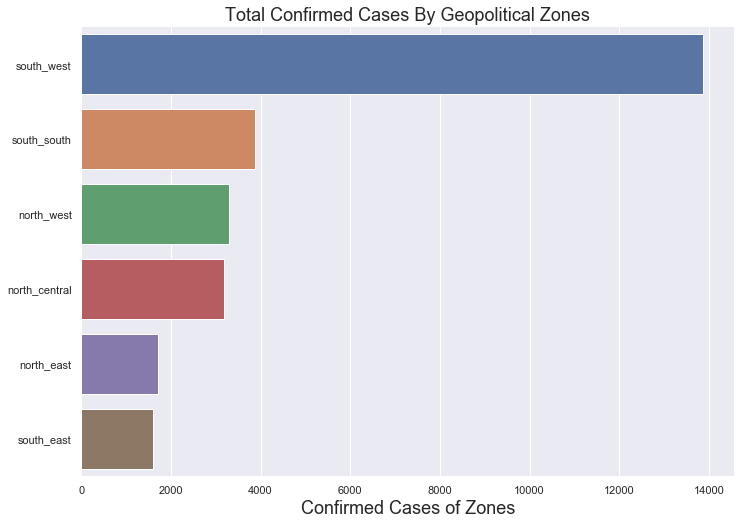

In [16]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='daily_zone_cases', y='geopolitical_zones', data=geopolitical_zone);
ax.set_title('Total Confirmed Cases By Geopolitical Zones', size = 18)
ax.set_xlabel('Confirmed Cases of Zones', size=18)
ax.set_ylabel('', size=18)
sns.despine(left=True)
plt.xticks(rotation=360)
plt.show()

## Medical Statistics

#### Case Fatality Rate(CFR)
$$\large CFR = \frac{Total Number of Death}{Total number Infected}$$

In [17]:
def case_fatality(df):
    total_death = df['deaths'].sum()
    total_confirm_cases = df['total_daily_cases'].sum()
    cfr = total_death/total_confirm_cases * 100
    return cfr
cfr = case_fatality(model_data)

print(f'The Case Fatality rate In Nigeria is: {round(cfr,1)}%')

The Case Fatality rate In Nigeria is: 2.3%


#### Mortality Rate
$$\large MR = \frac{Total Population}{Total Deaths}$$ 
[Estimated population of Nigeria](https://en.wikipedia.org/wiki/Demographics_of_Nigeria): 200 Million

In [36]:
def mortality_rate(df):
    estimated_population = 200000000
    covid_deaths = df['deaths'].sum()
    mr = covid_deaths/estimated_population
    return mr
mr = mortality_rate(model_data)
death_per1million = model_data['deaths'].sum()/1000000
print(f'The Mortality Rate of Covid19: {mr}, whereas deaths per one million is:{death_per1million}')

The Mortality Rate of Covid19: 3.14e-06, whereas deaths per one million is:0.000628


## Monthly Statistics

## Confirmed Cases By Month

In [21]:
def monthly_stats(df):
    #make_date_index = df.set_index(data_column)
    monthly_data = df.resample('M').agg({'deaths':'sum', 'total_daily_cases':'sum','discharged_recovered':'sum'})
    monthly_data['dates'] = monthly_data.index
    monthly_data['month'] = monthly_data['dates'].dt.month
    return monthly_data.drop('dates', axis=1)
df_month = monthly_stats(model_data)
df_month


deaths  total_daily_cases  discharged_recovered  month
Dates                                                             
2020-02-29       0                  1                     0      2
2020-03-31       2                137                     9      3
2020-04-30      56               1792                   310      4
2020-05-31     229               8232                  2688      5
2020-06-30     303              15533                  6739      6
2020-07-31      38               1870                  1323      7

### Monthly Confirmed Cases

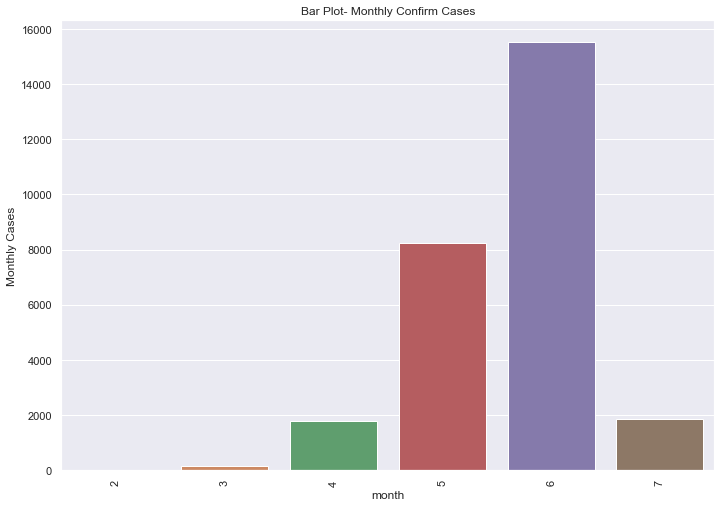

In [22]:
# Monthly confirmed cases
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='total_daily_cases', data=df_month)
ax.set_title('Bar Plot- Monthly Confirm Cases')
ax.set_ylabel('Monthly Cases')
plt.xticks(rotation = 90)
plt.show()

## Deaths By Month

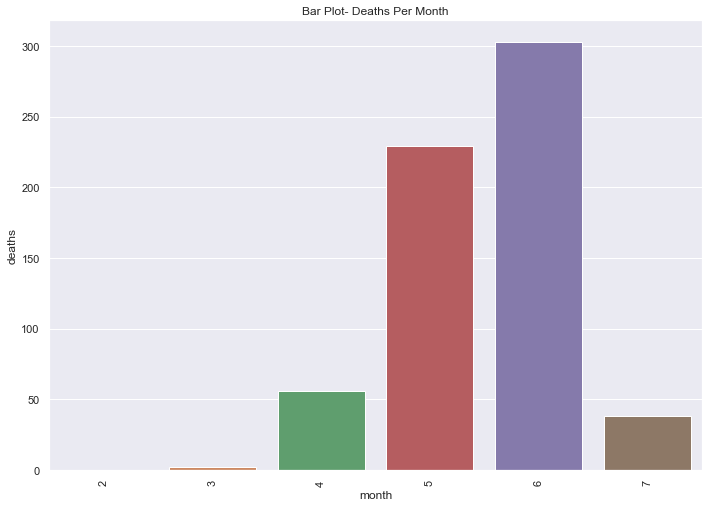

In [23]:
#Monthly Deaths
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='deaths', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## Recoveries By Month

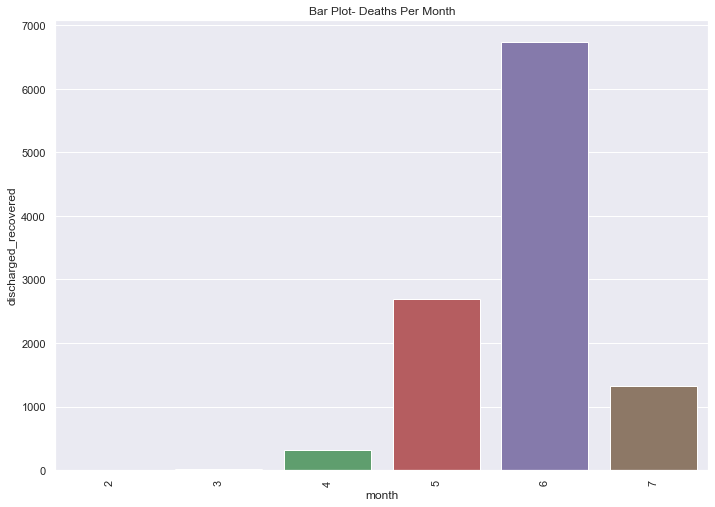

In [24]:
#Number of Recoveries by Month
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='discharged_recovered', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## States Data

In [25]:
state_data = load_ntm_data()
state_data.head()

shape of data: (36, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
States Affected                 36 non-null object
No. of Cases (Lab Confirmed)    36 non-null object
No. of Cases (on admission)     36 non-null object
No. Discharged                  36 non-null object
No. of Deaths                   36 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.5+ KB
checking for missing data: None


States Affected No. of Cases (Lab Confirmed) No. of Cases (on admission)  \
0           Lagos                       10,910                       9,147   
1             FCT                        2,080                       1,428   
2             Oyo                        1,451                         730   
3             Edo                        1,266                         623   
4            Kano                        1,262                         207   

  No. Discharged  No. of Deaths  
0          1,631            132  
1            617             35  
2            707             14  
3            596             47  
4          1,003             52

In [26]:
#clean_data
second_data = load_ntm_data()
affected_column = ['no._of_cases_(lab_confirmed)', 'no._of_cases_(on_admission)','no._discharged']
def polish_data(df):
    clean_columns = df.rename(columns=clean_col)
    for i in clean_columns.columns:
        if i in affected_column:
            clean_columns[i] = clean_columns[i].str.replace(',','').astype('int64')
    return clean_columns
cleany = polish_data(second_data)
cleany.head()

shape of data: (36, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
States Affected                 36 non-null object
No. of Cases (Lab Confirmed)    36 non-null object
No. of Cases (on admission)     36 non-null object
No. Discharged                  36 non-null object
No. of Deaths                   36 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.5+ KB
checking for missing data: None


states_affected  no._of_cases_(lab_confirmed)  no._of_cases_(on_admission)  \
0           Lagos                         10910                         9147   
1             FCT                          2080                         1428   
2             Oyo                          1451                          730   
3             Edo                          1266                          623   
4            Kano                          1262                          207   

   no._discharged  no._of_deaths  
0            1631            132  
1             617             35  
2             707             14  
3             596             47  
4            1003             52

In [27]:
def states_stat(df,st_col, st_death):
    death_by_state =  df[[st_col, st_death]].sort_values(st_death, ascending=False)
    return death_by_state
death_by_states = states_stat(cleany,'states_affected', 'no._of_deaths')


## Deaths By States

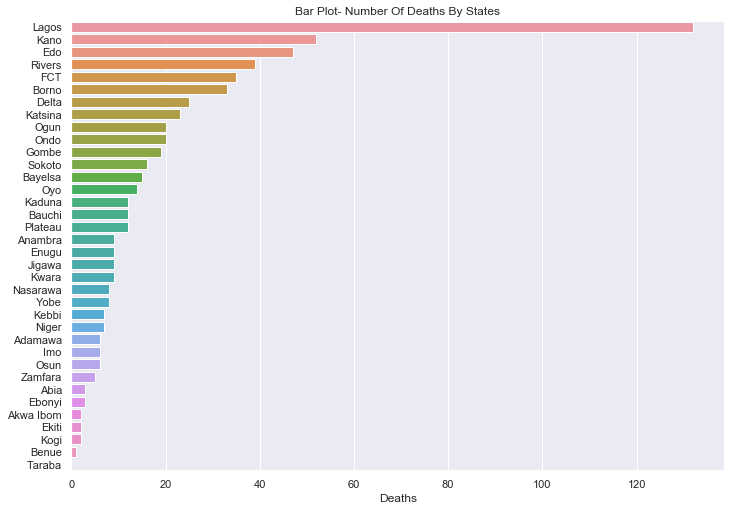

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_deaths', y='states_affected', data=death_by_states)
ax.set_title('Bar Plot- Number Of Deaths By States')
plt.xlabel('Deaths')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recoveries/Discharged By States

In [29]:
discharged_by_states = states_stat(cleany, 'states_affected', 'no._discharged')


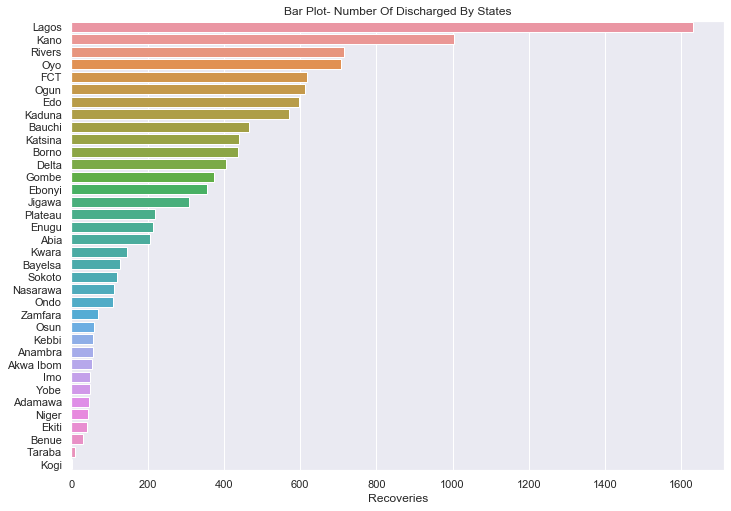

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._discharged',y='states_affected', data=discharged_by_states)
ax.set_title('Bar Plot- Number Of Discharged By States')
plt.xlabel('Recoveries')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## confirmed Cases By States

In [31]:
confirmed_cases_states = states_stat(cleany,'states_affected', 'no._of_cases_(lab_confirmed)')


### Confirmed Cases By States

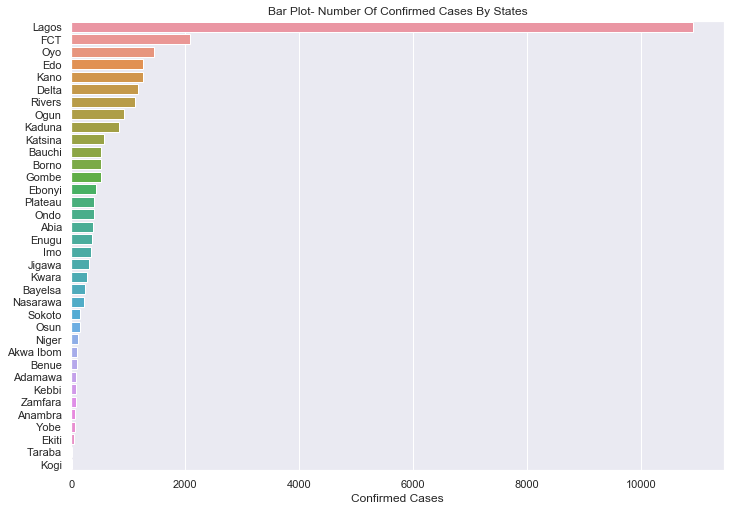

In [32]:
# Confirm cases spread across all states
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_cases_(lab_confirmed)',y='states_affected', data=confirmed_cases_states)
ax.set_title('Bar Plot- Number Of Confirmed Cases By States')
plt.xlabel('Confirmed Cases')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## Race Bar Chart

In [36]:
#get data into shape
nt_needed = ['cross_river','discharged_recovered','deaths','total_daily_cases','south_west','south_south','south_east','north_central','north_east','north_west']
def tidyrc_data(df):
    race_chart_data = df.drop(nt_needed, axis=1)
    clean_rc_data = race_chart_data.cumsum(axis=0)
    return clean_rc_data

clean_rb = tidyrc_data(clean_covid_ng)



In [35]:
bcr.bar_chart_race(clean_rb)

## Build  Logistic Model

### Predicting the Epidemic Situation of Covid19 In Nigeria with Logistic Mathematical Model
My choice of the Logistic Model is simply because it is simple and it conform to the statistical law of Epidemiology

In [40]:
#Preapre data
def clean_model_data(df):
    cumulate_data = df.cumsum(axis=0)
    clean_index = cumulate_data.reset_index()
    return clean_index
log_model_data = clean_model_data(model_data)


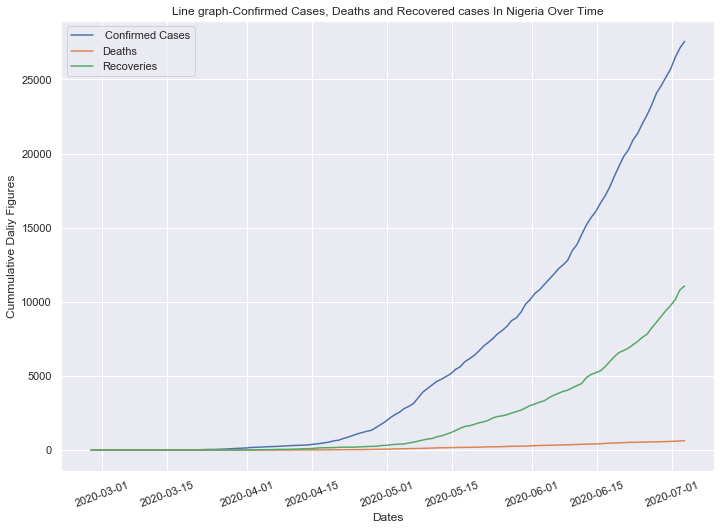

In [39]:
#Line graph of confirm cases over time
ax = sns.lineplot(x='Dates', y='total_daily_cases', data=log_model_data, label=' Confirmed Cases')
ax = sns.lineplot(x='Dates', y='deaths', data=log_model_data,label='Deaths')
ax = sns.lineplot(x='Dates', y='discharged_recovered', data=log_model_data, label='Recoveries')
plt.xticks(rotation=20)
ax.set_title('Line graph-Confirmed Cases, Deaths and Recovered cases In Nigeria Over Time')
ax.set_ylabel('Cummulative Daliy Figures')
ax.legend()
plt.show()




## Logistic Model
The logistic model can be simply rendered as $$\huge f(x;a,b,c) = \frac{c}{1 + e^-(x-b)/a}$$ 

where :
- a = **Infection speed**
- b = **Day with maximum Infections Occured**
- c = **Total Number of people that would be infected at the end of the pandemic**

In [66]:
def logistic_model(x,a,b,c,d):
    return a / (1 + np.exp(-c * (x - d))) + b

# def logistics_noise(a,b,c,d,t):
#     return abs(c/(1+a*np.exp(-b*t))+np.random.normal(0,d))

In [67]:
def build_data(df):
    df['time_stamp'] = df.index
    return df
build_model = build_data(log_model_data)
build_model.head()

Dates  total_daily_cases  deaths  discharged_recovered  \
0 2020-02-27 15:40:00                  1       0                     0   
1 2020-02-28 01:00:00                  1       0                     0   
2 2020-02-29 02:26:00                  1       0                     0   
3 2020-03-01 22:44:00                  1       0                     0   
4 2020-03-02 11:53:00                  1       0                     0   

   time_stamp  
0           0  
1           1  
2           2  
3           3  
4           4

In [68]:
# extract x(days) & y(cases) from dataframe
x = list(build_model.iloc[:,4])
y = list(build_model.iloc[:,1])


In [69]:
# randomly initialize a,b,c,d
p0 = np.random.exponential(size=4)
p0


array([0.20666184, 0.01345231, 0.39959063, 0.86242325])

In [70]:
# set upper and lower bounds a,b,c
bounds = (0,[100000.,1., 100000000., 100000.])
bounds

(0, [100000.0, 1.0, 100000000.0, 100000.0])

In [71]:
(a_, b_, c_,d_), cov = curve_fit(logistic_model,x,y,bounds=bounds, p0=p0)

In [72]:
a_,b_,c_,d_

(42993.5263086909,
 1.0421958746458338e-11,
 0.05328265148979222,
 123.83380106075175)

In [73]:
#the time step at which the growth is fastest
# t_fastest = np.log(a) / b
# i_fastest = logistic_model(t_fastest, a, b, c)
# i_fastest

In [74]:
conex = np.array(y)
conex

array([    1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     2,     2,     2,     2,     2,     2,     2,
           2,     3,     3,     3,     3,     6,    27,    39,    43,
          45,    50,    64,    69,    80,    88,    96,   110,   130,
         134,   138,   150,   173,   183,   189,   213,   223,   231,
         237,   253,   275,   289,   306,   319,   324,   344,   363,
         374,   408,   443,   494,   543,   629,   667,   784,   875,
         983,  1097,  1184,  1270,  1335,  1530,  1726,  1930,  2168,
        2388,  2557,  2802,  2950,  3145,  3525,  3911,  4150,  4398,
        4640,  4786,  4968,  5157,  5445,  5621,  5959,  6167,  6393,
        6677,  7016,  7261,  7526,  7839,  8068,  8344,  8733,  8915,
        9302,  9855, 10162, 10578, 10819, 11167, 11517, 11845, 12227,
       12487, 12802, 13465, 13874, 14555, 15182, 15683, 16086, 16659,
       17149, 17736, 18481, 19148, 19809, 20245, 20920, 21372, 22021,
       22615, 23299,

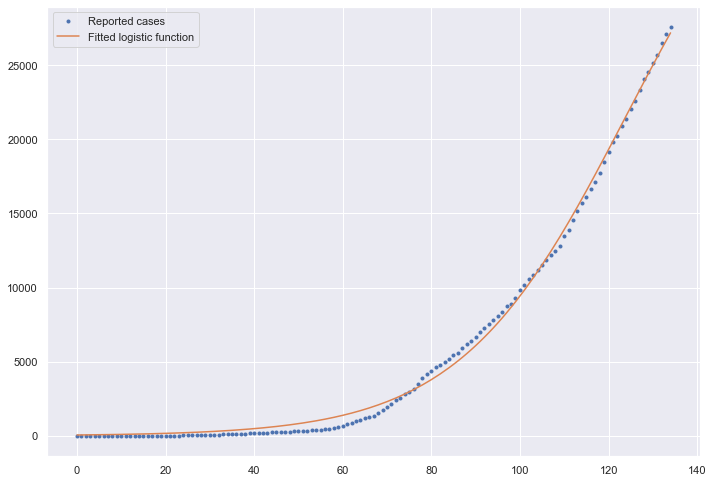

In [75]:
def plot_logistic_fit(confirmed, logistic_params):
    a_, b_, c_,d_ = logistic_params
    x = np.arange(0, len(build_model['time_stamp']))
    plt.plot(x, confirmed, ".", label="Reported cases")
    confirmed_pred = logistic_model(x, a_, b_, c_,d_)
    plt.plot(x, confirmed_pred, label="Fitted logistic function")
    plt.legend()
    plt.show()
    return confirmed_pred
confirmed_pred = plot_logistic_fit(conex, (a_, b_, c_,d_))


In [67]:
from sklearn.metrics import r2_score

In [68]:
#check Accuracy
r2_score(y,confirmed_pred)

0.027470621041988497

In [82]:
def plateau(con, logistic_params, diff=20):
    a_, b_, c_, d_ = logistic_params 
    confirmed_now = conex[-1]
    confirmed_then = conex[-2]
    days = 0
    now = x[-1]
    while (confirmed_now - confirmed_then) > diff:
        days += 1
        confirmed_then = confirmed_now
        confirmed_then = logistic_model(now + days,a_,b_,c_,d_)
    return days, confirmed_then
days, cases = plateau(conex,(a_,b_,c_,d_), diff=200)
#print(f"In {days} days the number of infected people/cases will platau at {cases}")
print(days)
print(cases)

1
27709.476582777286


In [81]:
conex[-1] - conex[-2]

454

In [71]:
# diff = 200
# days, cases = plateau(y, (a_, b_, c_, d_),diff=diff)
# print(f"{days} days until growth is lower than {diff} per day")
# print(f"The total cases will be at {int(cases)}")